In [3]:
pip install opencv-python

  Using cached opencv_python-4.6.0.66-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (60.9 MB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install opencv-python-headless

  Using cached opencv_python_headless-4.6.0.66-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (48.3 MB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from scipy import ndimage, misc
from matplotlib import pyplot
import tensorflow as tf
import numpy as np
np.random.seed(0)
import re
import os
import cv2

2022-06-12 03:41:10.502045: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [6]:
def lowResolution(path,highsize,lowscale):
    names = sorted(os.listdir(path))
    allLowImages = []
    for name in names:
        fpath = path + name
        img = cv2.imread(fpath, cv2.IMREAD_COLOR)
        image=cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        image = cv2.resize(image,(int(highsize),int(highsize)),cv2.INTER_CUBIC) 
        image = cv2.resize(image,(int(lowscale),int(lowscale)),cv2.INTER_CUBIC) 
        lowimage=image[:, :, :].astype(float) / 255 
        
        allLowImages.append(lowimage) 
    allLowImages = np.array(allLowImages)
    return allLowImages

In [7]:
def highResolution(path,size):
    names = sorted(os.listdir(path))
    allHighimages = []
    for name in names:
        fpath = path + name
        img = cv2.imread(fpath, cv2.IMREAD_COLOR)
        image=cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #change bgr to rgb
        
        highimage = cv2.resize(image,(size,size),cv2.INTER_CUBIC) 
        highimage=highimage[:, :, :].astype(float) / 255 
        
        allHighimages.append(highimage) 
    allHighimages = np.array(allHighimages)
    return allHighimages

In [20]:
scale_factor=8
input_img = Input(shape=(None, None, 3))
l1 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu', 
            activity_regularizer = regularizers.l1(10e-10))(input_img)

l2 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu', 
            activity_regularizer = regularizers.l1(10e-10))(l1)

l3 = MaxPooling2D(padding = 'same')(l2)   
l3 = Dropout(0.3)(l3)

l4 = Conv2D(128, (3, 3),  padding = 'same', activation = 'relu', 
            activity_regularizer = regularizers.l1(10e-10))(l3)

l5 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu', 
            activity_regularizer = regularizers.l1(10e-10))(l4)

l6 = MaxPooling2D(padding = 'same')(l5) #2

l7 = Conv2D(256, (3, 3), padding = 'same', activation = 'relu', 
            activity_regularizer = regularizers.l1(10e-10))(l6)
l8 = Conv2DTranspose(256, (2,2), strides=(2,2))(l7)

l9 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu',
            activity_regularizer = regularizers.l1(10e-10))(l8)

l10 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu',
             activity_regularizer = regularizers.l1(10e-10))(l9)     # 2  /   2 

l11 = add([l5, l10])
l12 = Conv2DTranspose(128, (2,2), strides=(2,2))(l11)

l13 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu',
             activity_regularizer = regularizers.l1(10e-10))(l12)

l14 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu',
             activity_regularizer = regularizers.l1(10e-10))(l13)

l15 = add([l14, l2])
postUpsampling= Conv2DTranspose(64, (2,2), strides=(2,2))(l15)

X_up = Conv2D(64 * (scale_factor ** 2), 3, strides=(2,2), padding='same')(l15)
postUpsampling = tf.nn.depth_to_space(X_up, scale_factor)


decoded = Conv2D(3, (3, 3), padding = 'same', 
                 activation = 'relu', activity_regularizer = regularizers.l1(10e-10))(postUpsampling)


autoencoder = Model(input_img, decoded)

In [21]:
autoencoder.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_55 (Conv2D)              (None, None, None, 6 1792        input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_56 (Conv2D)              (None, None, None, 6 36928       conv2d_55[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, None, None, 6 0           conv2d_56[0][0]                  
____________________________________________________________________________________________

In [22]:
autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics='accuracy')

In [23]:
x_train_low=lowResolution("./data/train_data/DIV2K_train_HR/",400,100)

In [24]:
x_train_high=highResolution("./data/train_data/DIV2K_train_HR/",400)

In [25]:
print(x_train_low.shape)

(900, 100, 100, 3)


In [26]:
print(x_train_high.shape)

(900, 400, 400, 3)


Text(0.5, 1.0, 'high resolution ')

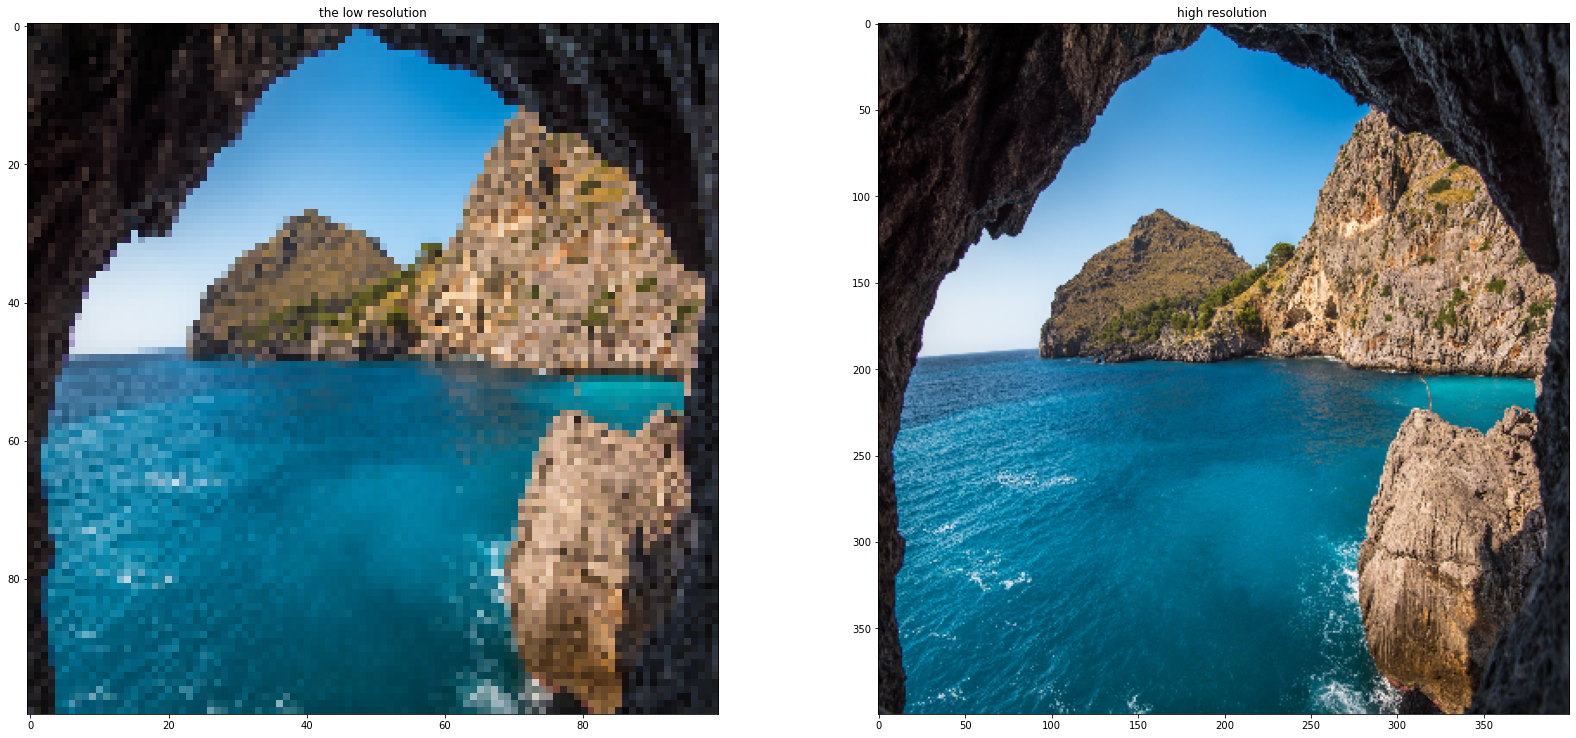

In [27]:
plt.figure(figsize = (150, 150))
i = 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_low[50])
plt.title("the low resolution")
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_high[50])
plt.title("high resolution ")

In [28]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)

In [29]:
history=autoencoder.fit(x_train_low, x_train_high,epochs=120,batch_size=10,shuffle=True, callbacks=[callback],validation_split=0.2)

2022-06-12 03:50:21.595107: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1382400000 exceeds 10% of free system memory.
2022-06-12 03:50:21.947322: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-12 03:50:21.975105: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


Epoch 1/120


2022-06-12 03:50:23.255220: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-06-12 03:50:25.758129: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-06-12 03:50:25.972358: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-06-12 03:50:28.831616: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


72/72 [==============================] - ETA: 0s - loss: 0.0610 - accuracy: 0.5127

2022-06-12 03:51:59.812895: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 345600000 exceeds 10% of free system memory.


72/72 [==============================] - 100s 291ms/step - loss: 0.0605 - accuracy: 0.5144 - val_loss: 0.0109 - val_accuracy: 0.7084
Epoch 2/120
72/72 [==============================] - 21s 286ms/step - loss: 0.0106 - accuracy: 0.7881 - val_loss: 0.0093 - val_accuracy: 0.7976
Epoch 3/120
72/72 [==============================] - 21s 288ms/step - loss: 0.0095 - accuracy: 0.8334 - val_loss: 0.0091 - val_accuracy: 0.8391
Epoch 4/120
72/72 [==============================] - 21s 289ms/step - loss: 0.0102 - accuracy: 0.8430 - val_loss: 0.0090 - val_accuracy: 0.8472
Epoch 5/120
72/72 [==============================] - 21s 290ms/step - loss: 0.0093 - accuracy: 0.8624 - val_loss: 0.0089 - val_accuracy: 0.8300
Epoch 6/120
72/72 [==============================] - 21s 292ms/step - loss: 0.0093 - accuracy: 0.8462 - val_loss: 0.0088 - val_accuracy: 0.8463
Epoch 7/120
72/72 [==============================] - 21s 293ms/step - loss: 0.0095 - accuracy: 0.8515 - val_loss: 0.0089 - val_accuracy: 0.8432
Epo

In [30]:
autoencoder.save('Autoencoder_42ep_Subpixel_model.h5') 

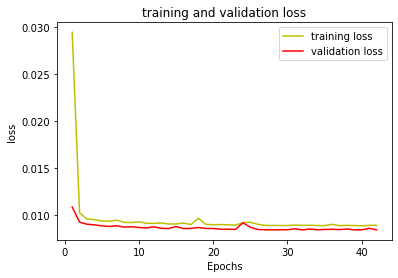

In [31]:
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epochs=range(1,len(loss)+1)
plt.plot(epochs,loss,'y',label="training loss")
plt.plot(epochs,val_loss,'r',label="validation loss")
plt.title("training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

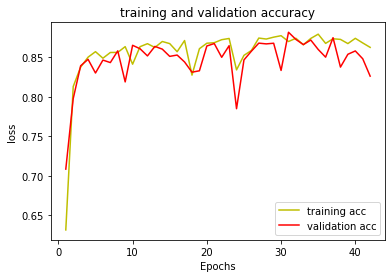

In [32]:
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
epochs=range(1,len(loss)+1)
plt.plot(epochs,acc,'y',label="training acc")
plt.plot(epochs,val_acc,'r',label="validation acc")
plt.title("training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [35]:
print(history.history)

{'loss': [0.11991478502750397, 0.07821556180715561, 0.06418616324663162, 0.039538830518722534, 0.027744099497795105, 0.025766974315047264, 0.02562451921403408, 0.02554575353860855, 0.025470489636063576, 0.025474095717072487, 0.02536088600754738, 0.025329023599624634, 0.02536182664334774, 0.025274716317653656, 0.02525726705789566, 0.025245020166039467, 0.025214174762368202, 0.02520723268389702, 0.025241665542125702, 0.02515443228185177, 0.025136878713965416, 0.02512187510728836, 0.025178324431180954, 0.025111738592386246, 0.025122836232185364, 0.02513224072754383, 0.025090357288718224, 0.025058714672923088, 0.0250831451267004, 0.025048311799764633, 0.025220319628715515, 0.02501724101603031, 0.025017024949193, 0.024993006139993668, 0.024989811703562737, 0.024977289140224457, 0.02498740889132023, 0.024992303922772408, 0.024978404864668846, 0.02500811219215393, 0.02499101497232914, 0.02501697465777397, 0.024992579594254494, 0.025012623518705368, 0.024936119094491005, 0.024945132434368134, 